In [1]:
import sys 
import pandas as pd
import numpy as np
import itertools
import math
import warnings
import threading
import matplotlib.pyplot as plt
import time
from pprint import pprint

In [2]:

'''Get inputs as group1, group2, Donor-Acceptor distance,angle cutoff from the user '''
   
natoms=int(input('Enter the number of atoms: '))

group1=[]
nums=[num for num in input("Enter list of atoms like 2,5,6-10, For all press Enter: ").strip().split(',')]
for i in nums:
     if i=='':
         break
     if "-" in i:
         m=i.split('-')
         for j in range(int(m[0]), int(m[1])+1,1):
             group1.append(int(j))        
     else:
         group1.append(int(i))
group1=sorted(group1)

 
group2=[]
nums=[num for num in input("Enter list of atoms like 2,5,6-10, For all press Enter: ").strip().split(',')]
for i in nums:
     if i=='':
         break
     if "-" in i:
         m=i.split('-')
         for j in range(int(m[0]), int(m[1])+1,1):
             group2.append(int(j))        
     else:
         group2.append(int(i))
group2=sorted(group2)

      
cutoff_distance=float(input('Enter the Donor-Acceptor distance in Angstrom like 3.5: '))
cutoff_angle=float(input('Enter the angle cutoff in degree like 30: '))


Enter the number of atoms: 621
Enter list of atoms like 2,5,6-10, For all press Enter: 
Enter list of atoms like 2,5,6-10, For all press Enter: 
Enter the Donor-Acceptor distance in Angstrom like 3.5: 3.5
Enter the angle cutoff in degree like 30: 30


In [4]:
def read_trajectory(filename,frame=None,selection1=None,selection2=None):
         ''' read the file, skips first two lines and create atom_list, and atom_info list'''
         with open (filename) as tf:
            for line in itertools.islice(tf, frame*(natoms+2), (frame+1)*(natoms+1)):
                tf.readline()
                tl=pd.read_csv(tf,sep='\s+', header=None, nrows=natoms,names="element x y z".split())
                if selection1 and selection2:
                    selection1=[(tl["element"][s],tl["x"][s],tl["y"][s],tl["z"][s]) for s in selection1]
                    selection2=[(tl["element"][s],tl["x"][s],tl["y"][s],tl["z"][s]) for s in selection2]
                else:
                    selection1=selection2=list(zip(tl["element"],tl["x"],tl["y"],tl["z"])) 
                tot=list(zip(tl["element"],tl["x"],tl["y"],tl["z"]))
                return(selection1,selection2,tot)  

In [5]:
def atom_groups(selection1,selection2):
        h_list=[]
        donor_list=[]
        acceptor_list=[]
        select=['O','N','F','Zn']       

        '''Find D-H (Donor and hydrogen) groups''' #bond={'NH': 0.99,'OH': 0.98} 
        for i  in range(len(selection1)):
            if selection1[i][0]=='H':
                h_list.append(i)
                
        for i  in range(len(selection1)):   
              if selection1[i][0] in select:
                    for j in h_list:
                        if round(math.dist((selection1[i][1],selection1[i][2],selection1[i][3]),
                                           (selection1[j][1],selection1[j][2],selection1[j][3])),1)<=1.0:
                            donor_list.append((i,j)) 
                    
        '''Find Acceptor groups''' 
        for i  in range(len(selection2)):
              if selection2[i][0] in select:
                    acceptor_list.append(i)
    #   print(len(donor_list))
     #   print(len(acceptor_list))
        return(donor_list,acceptor_list) 

In [6]:
def angle(i,j,k):
    '''calcualte angle between i,j,k
    >>> angle((1,0,0),(0,0,0),(-1,0,0))  
    180.0    
    '''
    a = np.array(i)
    b = np.array(j)
    c = np.array(k)
    f=b-a
    e=b-c
    cosine_angle = np.dot(f, e) / (np.linalg.norm(f) * np.linalg.norm(e))
    warnings.simplefilter("ignore")
    angle = np.degrees(np.arccos(cosine_angle))
    return(angle)
#import doctest
#doctest.testmod()

In [7]:
def hbond(traj_input,frame,group1,group2):
         data=read_trajectory(traj_input,frame,group1,group2)
         selection1=data[0]
         selection2=data[1]
         tot=data[2]
         data2=atom_groups(selection1,selection2)
         donor_list=data2[0]
        # print(donor_list)
         acceptor_list=data2[1]
        # print(acceptor_list)
         hbond=0  
         for (d,h) in donor_list:
             for a in acceptor_list:
                 distance=math.dist((selection2[a][1],selection2[a][2],selection2[a][3]),(selection1[d][1],selection1[d][2],selection1[d][3]))
                 angles=angle((selection2[a][1],selection2[a][2],selection2[a][3]),(selection1[d][1],selection1[d][2],selection1[d][3]),(selection1[h][1],selection1[h][2],selection1[h][3]))      
                 if round(distance,2)<= cutoff_distance:    
                       if round(angles,2)<=cutoff_angle:
                         #   print((tot.index(selection2[a]),tot.index(selection1[d]),tot.index(selection1[h])), distance, angles)
                            hbond +=1
         return((frame,hbond))            

In [10]:
import pylab
from pylab import *
fig = plt.figure(figsize=(1.2*6,6)) 


data01 = np.genfromtxt((r for r in open('vmd2.dat') if not r[0] in ('@', '#', '&')))
frame = data01.T[0]  # time in ps
hbond = data01.T[1]



# make a plot of Potential energy vs simulation steps
plt.plot(x_val,y_val, marker='.', color='black', linestyle='-', lw=1.5, zorder = 500,
         markeredgewidth=1, alpha=0.92, label='Mycode')
plt.plot(frame,hbond, marker='.', color='red', linestyle='-', lw=1.5, zorder = 500,
         markeredgewidth=1, alpha=0.92, label='VMD')


xlabel('Frames', size=15)
ylabel('Hbond Number', size=15)
pylab.yticks(fontsize=12)
pylab.xticks(fontsize=12)


plt.legend(loc='best', ncol=1, columnspacing=2, handletextpad=0.5,
           fancybox=True, numpoints=1, markerscale=0.75, fontsize=12).set_alpha(0.5)


pylab.xlim([0,1000])


ax = fig.add_subplot(111)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

pylab.savefig('hbond.png', format='png', bbox_inches='tight')
plt.show()

NameError: name 'x_val' is not defined

<Figure size 518.4x432 with 0 Axes>

In [10]:
hbond_n=[]
def main(traj=None,b=None,e=None):
    traj_input=traj
    b=int(b)
    e=int(e)
 #   out_file = open("myfile.csv", "w")

    for i in range (b,e):
        frame=i
        n=hbond(traj_input,frame,group1,group2)
        hbond_n.append(n)

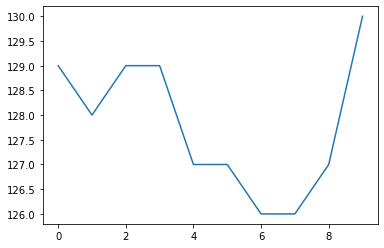

CPU times: user 15.2 s, sys: 0 ns, total: 15.2 s
Wall time: 15.1 s


In [13]:
%%time    
main('surface-1-pos-1.xyz',0,10) 
x_val=[x[0] for x in hbond_n]
y_val=[x[1] for x in hbond_n]
fig=plt.plot(x_val,y_val)
plt.show()

In [31]:
import threading
from multiprocessing import Queue
hbond_n=[]
threads = []
que = Queue()
def threads(traj=None,b=None,e=None):
    traj_input=traj
    b=int(b)
    e=int(e)
    for i in range (b,e):
        frame=i
        t = threading.Thread(target=lambda q, arg1: q.put(hbond('surface-1-pos-1.xyz',frame,group1,group2)),
                             args=(que, frame))
        
        threads.append(t)
        t.start()
    for t in threads:
        t.join() 
        
    while not que.empty():
        hbond_n.append (que.get())


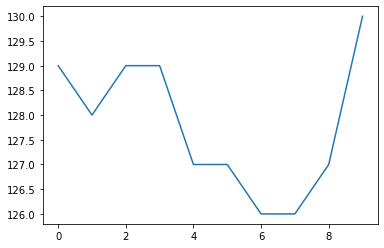

CPU times: user 26.9 s, sys: 6.26 s, total: 33.2 s
Wall time: 23.7 s


In [30]:
%%time    
threads('surface-1-pos-1.xyz',0,10)
hbond_n.sort()
fig=plt.plot([x[0] for x in hbond_n],[x[1] for x in hbond_n])
plt.show()

In [32]:
import multiprocessing as mp
hbond_n=[]
processes = []
que = mp.Queue()
def multiprocess(traj=None,b=None,e=None):
    traj_input=traj
    b=int(b)
    e=int(e)
    for i in range (b,e):
        frame=i
        p = mp.Process(target=lambda q, arg1: q.put(hbond('surface-1-pos-1.xyz',frame,group1,group2)),
                             args=(que, frame))
        processes.append(p)
        p.start()
    for p in processes:
        p.join() 
        
    while not que.empty():
        hbond_n.append (que.get())

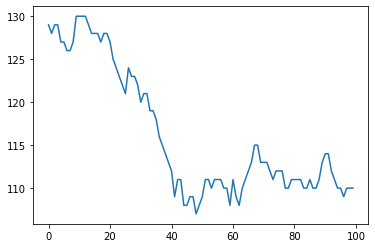

CPU times: user 161 ms, sys: 154 ms, total: 315 ms
Wall time: 22.9 s


In [33]:
%%time    
multiprocess('surface-1-pos-1.xyz',0,100)
hbond_n.sort()
fig=plt.plot([x[0] for x in hbond_n],[x[1] for x in hbond_n])
plt.show()